# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Final Project: Trumps Tweets

**Group Members**: Sarah Chin, Maleah Fekete, Mason Watson, Jasper Fu

In [1]:
# RUN THIS CELL FOR FORMAT
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import random
random.seed(112358)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statistics

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans 

from datetime import datetime

from sklearn import tree
%matplotlib inline

from gensim import models
import nltk
nltk.download('wordnet')
from nltk import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package wordnet to /Users/mkw/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
trump_tweets = pd.read_csv("data/trump-tweets/trump_tweet.csv")
poll_df = pd.read_csv("data/trump-approval-ratings/approval_topline.csv")

In [3]:
google_word2vec = models.KeyedVectors.load_word2vec_format('models/GoogleNews-vectors-negative300.bin', binary=True)

# Data Inspection and Cleaning 

## Trump Data

In [4]:
trump_tweets.head()

source                                               text  \
0  Twitter for iPhone  It was my great honor to deliver the keynote a...   
1  Twitter for iPhone  Thank you @robertjeffress! https://t.co/o6mk8o...   
2  Twitter for iPhone  RT @GaryCoby: Today @realDonaldTrump is receiv...   
3  Twitter for iPhone  Heading to South Carolina! https://t.co/CORtaP...   
4  Twitter for iPhone  RT @gatewaypundit: Breaking Poll: 52% Say Impe...   

            created_at  retweet_count favorite_count is_retweet        id_str  
0  10-25-2019 19:51:43         5132.0          16938      false  1.187819e+18  
1  10-25-2019 17:57:25         6095.0          22287      false  1.187790e+18  
2  10-25-2019 17:35:13         5810.0              0       true  1.187785e+18  
3  10-25-2019 17:30:21         8900.0          40776      false  1.187783e+18  
4  10-25-2019 16:22:09         7649.0              0       true  1.187766e+18

In [5]:
# Drop this entry because it provides no information under the analyses we are currently performing
trump_tweets = trump_tweets[~trump_tweets.text.isnull()]

# Create new dataframe with null values
trump_tweets = trump_tweets[~trump_tweets.id_str.isnull()]

# Drop indices with a lot of null entries from the main dataframe
trump_tweets = trump_tweets[~trump_tweets.id_str.isnull()]

# The entries with null retweet_count are the same as the entries will
# null favorite_count and null created_at
# These are also included in the entries with null id_str 
# We will group all of these into a separate dataframe to deal with null entries

In [ ]:
# display(trump_tweets[trump_tweets.id_str.isnull() == True])

In [ ]:
trump_tweets.dtypes

We notice that favorite_count is an object instead of an number, so we need to convert it before continuing with EDA. We will also change created_at to a DateTime object

In [6]:
trump_tweets["created_at"] = pd.to_datetime(trump_tweets['created_at'], errors='coerce')
trump_tweets["favorite_count"] = pd.to_numeric(trump_tweets["favorite_count"])

In [ ]:
trump_tweets.dtypes

## Poll Data

In [7]:
poll_df.dtypes

subgroup                object
modeldate               object
approve_estimate       float64
approve_hi             float64
approve_lo             float64
disapprove_estimate    float64
disapprove_hi          float64
disapprove_lo          float64
timestamp               object
dtype: object

In [8]:
# We noticed modeldate and timestamp were 'object' type so we converted them to dteday
timestamps = pd.to_datetime(poll_df.timestamp)
dates = pd.to_datetime(poll_df.modeldate)

poll_df.timestamp = timestamps
poll_df.modeldate = dates

# Sort the entries by date
sorted_df = poll_df.sort_values(by = ["modeldate"])
sorted_df.dtypes
sorted_df = sorted_df.reset_index(drop = True)

# EDA

## Trump Tweets

In [ ]:
# scaler = MinMaxScaler()
# trump_tweets_main[['favorite_count', 'retweet_count']] = scaler.fit_transform(trump_tweets_main[['favorite_count', 'retweet_count']])

# trump_tweets_main["fbyr"] = np.log(trump_tweets_main["favorite_count"] / trump_tweets_main["retweet_count"])

# trump_tweets_main.dtypes

In [ ]:
# trump_retweets = trump_tweets_main[trump_tweets_main.is_retweet == 'true']
# trump_not_retweets = trump_tweets_main[trump_tweets_main.is_retweet == 'false']

In [ ]:
# trump_retweets.describe()

In [ ]:
# trump_not_retweets.describe()

In [ ]:
# plt.scatter(trump_tweets_main['created_at'], trump_tweets_main["retweet_count"])
# plt.xlabel("date of tweet")
# plt.ylabel("retweet count")
# plt.title("retweet count over time")
# plt.show()

# plt.scatter(trump_tweets_main['created_at'], trump_tweets_main["favorite_count"])
# plt.xlabel("date of tweet")
# plt.ylabel("favorite count")
# plt.title("favorite count over time")
# plt.show()

# plt.scatter(trump_tweets_main['created_at'], trump_tweets_main["fbyr"], )
# plt.ylabel("favorite/retweet ratio (log)")
# plt.xlabel("date of tweet")
# plt.title("favorite/retweet ratio (log) count over time")
# plt.show()

## Poll Data

/Users/mkw/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Approval Rating Estimates')

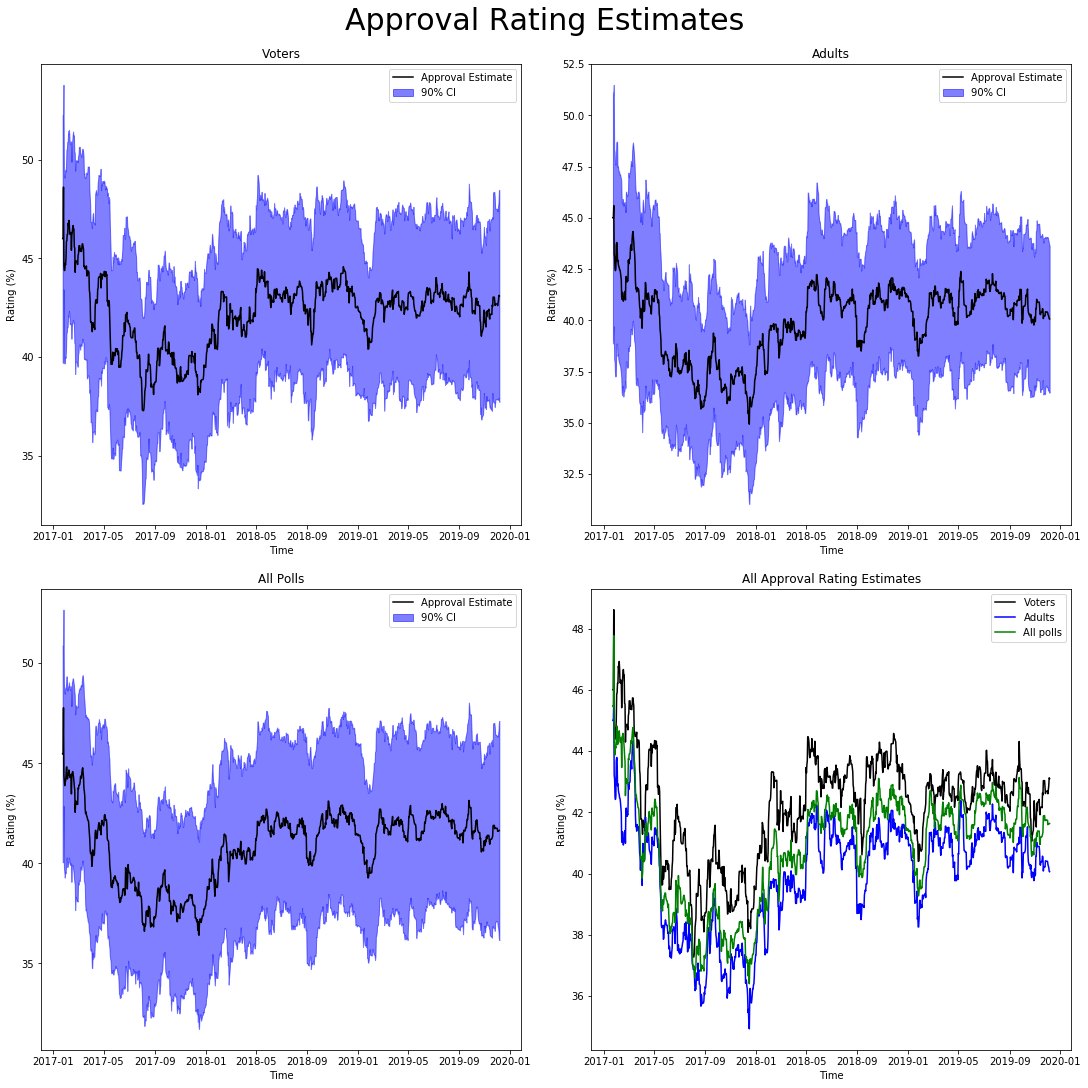

In [9]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15,15), constrained_layout = True)

ax[0][0].plot(sorted_df[sorted_df.subgroup == "Voters"].modeldate,
           sorted_df[sorted_df.subgroup == "Voters"].approve_estimate, color = 'k', label = "Approval Estimate")
ax[0][0].fill_between(sorted_df[sorted_df.subgroup == "Voters"].modeldate,
                 sorted_df[sorted_df.subgroup == "Voters"].approve_lo,
                 sorted_df[sorted_df.subgroup == "Voters"].approve_hi, color = 'b', alpha = 0.5, label = "90% CI")
ax[0][0].legend()
ax[0][0].set_title("Voters")
ax[0][0].set_xlabel("Time")
ax[0][0].set_ylabel("Rating (%)")

ax[0][1].plot(sorted_df[sorted_df.subgroup == "Adults"].modeldate,
           sorted_df[sorted_df.subgroup == "Adults"].approve_estimate, color = 'k', label = 'Approval Estimate')
ax[0][1].fill_between(sorted_df[sorted_df.subgroup == "Adults"].modeldate,
                 sorted_df[sorted_df.subgroup == "Adults"].approve_lo,
                 sorted_df[sorted_df.subgroup == "Adults"].approve_hi, color = 'b', alpha = 0.5, label = "90% CI")
ax[0][1].legend()
ax[0][1].set_title("Adults")
ax[0][1].set_xlabel("Time")
ax[0][1].set_ylabel("Rating (%)")

ax[1][0].plot(sorted_df[sorted_df.subgroup == "All polls"].modeldate,
           sorted_df[sorted_df.subgroup == "All polls"].approve_estimate, color = 'k', label = "Approval Estimate")
ax[1][0].fill_between(sorted_df[sorted_df.subgroup == "All polls"].modeldate,
                 sorted_df[sorted_df.subgroup == "All polls"].approve_lo,
                 sorted_df[sorted_df.subgroup == "All polls"].approve_hi, color = 'b', alpha = 0.5, label = "90% CI")
ax[1][0].legend()
ax[1][0].set_title("All Polls")
ax[1][0].set_xlabel("Time")
ax[1][0].set_ylabel("Rating (%)")

ax[1][1].plot(sorted_df[sorted_df.subgroup == "Voters"].modeldate,sorted_df[sorted_df.subgroup == "Voters"].approve_estimate, color = 'k', label = "Voters")
ax[1][1].plot(sorted_df[sorted_df.subgroup == "Adults"].modeldate,sorted_df[sorted_df.subgroup == "Adults"].approve_estimate, color = 'b', label = "Adults")
ax[1][1].plot(sorted_df[sorted_df.subgroup == "All polls"].modeldate,sorted_df[sorted_df.subgroup == "All polls"].approve_estimate, color = 'g', label = "All polls")
ax[1][1].legend()
ax[1][1].set_title("All Approval Rating Estimates")
ax[1][1].set_xlabel("Time")
ax[1][1].set_ylabel("Rating (%)")

plt.suptitle("Approval Rating Estimates", fontsize = 30)



Just by looking at the graphs, it doesn't look like the data from just adult population and the data from just the voter population vary much from the data from all polls, but we can also check this by measuring the data similarity.

In [10]:
# Evaluate similarity scores between the data

def similarity(list1,list2):
    x = []
    for i in range(len(list1)):
        x.append(abs(list1[i] - list2[i]))
    return np.mean(x)

similar_adults_voters = similarity(list(sorted_df[sorted_df.subgroup == "Adults"].approve_estimate), list(sorted_df[sorted_df.subgroup == "Voters"].approve_estimate))
similar_adults_all = similarity(list(sorted_df[sorted_df.subgroup == "Adults"].approve_estimate), list(sorted_df[sorted_df.subgroup == "All polls"].approve_estimate))
similar_voters_all = similarity(list(sorted_df[sorted_df.subgroup == "Voters"].approve_estimate), list(sorted_df[sorted_df.subgroup == "All polls"].approve_estimate))

print(similar_adults_voters, similar_adults_all, similar_voters_all)
print(2*np.std(sorted_df[sorted_df.subgroup == "Adults"].approve_estimate), 
      2*np.std(sorted_df[sorted_df.subgroup == "Voters"].approve_estimate), 
      2*np.std(sorted_df[sorted_df.subgroup == "All polls"].approve_estimate))

2.2729759942748093 0.923133264312977 1.3530266612595423
3.5522695473266834 3.4286256037833427 3.5950257015139337


Our similarity scores are all within two standard deviations, so it is sufficient to just choose one set of data - we'll use "All polls" - for our project as it is is a larger population and should grant us more statistical power.

# Feature Engineering 

## Extraction of Usable Features from Tweet Data

### Getting rid of URL links and Twitter handles

In [11]:
stop_words = ["iphone", "android", "twitter", "give", "want", "think", "do", "anything", "n't", "really", "get",
              "know", "go", "watch", "good", "great", "&", "not", "can't", "%", "@", "#",
              "rt", "amp", ".", ",", "!", "?", ":", "i", "me", "my", "myself", "we", "our",
              "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he",
              "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
              "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom",
              "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been",
              "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
              "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by",
              "for", "with", "about", "against", "between", "into", "through", "during", "before",
              "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off",
              "over", "under", "again", "further", "then", "once", "here", "there", "when", "where",
              "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some",
              "such", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will",
              "just", "don", "should", "now"]

In [12]:
#un-capitalize
trump_tweets['fix_text'] = trump_tweets['text'].apply(lambda x : str.lower(x))

#getting rid of stopwords
trump_tweets['fix_text'] = trump_tweets['fix_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

trump_tweets['fix_text']

# #getting rid of URLs (and handles)
trump_tweets['fix_text'] = trump_tweets['fix_text'].str.replace(r'http\S+', '').astype('str')

# #stemming and lemmatizing
ps = PorterStemmer()
lmtzr = WordNetLemmatizer()

trump_tweets['fix_text'] = trump_tweets['fix_text'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))
trump_tweets['fix_text'] = trump_tweets['fix_text'].apply(lambda x: ' '.join([lmtzr.lemmatize(word, 'v') for word in x.split()]))

# #tokenize
trump_tweets['fix_text'] = trump_tweets['fix_text'].apply(word_tokenize)
trump_tweets['fix_text'] = trump_tweets['fix_text'].apply(lambda x: [word for word in x if word not in (stop_words)])

In [13]:
trump_tweets['fix_text'].to_csv(header=True)

',fix_text\n0,"[\'honor\', \'deliv\', \'keynot\', \'address\', \'2019\', \'second\', \'step\', \'presidenti\', \'justic\', \'forum\', \'host\', \'20/20\', \'bipartisan\', \'justic\', \'center\', \'south\', \'carolina\', \'true\', \'honor\', \'receiv\', \'bipartisan\', \'justic\', \'award\', \'thank\']"\n1,"[\'thank\', \'robertjeffress\']"\n2,"[\'garycoby\', \'today\', \'realdonaldtrump\', \'receiv\', \'bipartisan\', \'justic\', \'award\', \'histor\', \'work\', \'crimin\', \'justic\', \'reform.at\', \'sa…\']"\n3,"[\'head\', \'south\', \'carolina\']"\n4,"[\'gatewaypundit\', \'break\', \'poll\', \'52\', \'say\', \'impeach\', \'polit\', \'stunt\', \'democrat\', \'-\', \'59\', \'say\', ""\'"", \'wast\', \'time\', \'danscavino\', \'realdonal…\']"\n5,"[\'“\', \'donald\', \'j.\', \'trump\', \'absolut\', \'histor\', \'presid\', \'alreadi\', \'less\', \'3\', \'year\', \'office\', \'record\', \'everyon\', \'look\', \';\', \'examin\', \'compare\', \'illegitim\', \'effort\', \'overthrow\', \'presid

In [14]:
trump_tweets['fix_text'].head()

0    [honor, deliv, keynot, address, 2019, second, ...
1                              [thank, robertjeffress]
2    [garycoby, today, realdonaldtrump, receiv, bip...
3                              [head, south, carolina]
4    [gatewaypundit, break, poll, 52, say, impeach,...
Name: fix_text, dtype: object

In [15]:
tweet_vectors = np.zeros((trump_tweets.shape[0], 300))
word_vectors = []

for i in range(trump_tweets.shape[0]):
    tokenized_tweet = trump_tweets['fix_text'].iloc[i]
    n = len(tokenized_tweet)
    
    for j in range(n):
        try:
            word_vectors.append(google_word2vec.get_vector(tokenized_tweet[j]))
        except:
            pass
        
kmeanModel = KMeans(n_clusters=20).fit(word_vectors)

for k in range(20):
    display(google_word2vec.most_similar(positive=[kmeanModel.cluster_centers_[k]], topn=5))

[('democrat', 0.7904107570648193),
 ('election', 0.7395635843276978),
 ('vote', 0.7361090779304504),
 ('democrats', 0.7132264375686646),
 ('elections', 0.6925697326660156)]

[('michael@newser.com', 0.6004522442817688),
 ('www.credoaction.com_sirota', 0.5990284085273743),
 ('blamb@theadvocate.com', 0.5944478511810303),
 ('iMeMiner_automatically_grabs', 0.5915631055831909),
 ('aide_Daniel_Ketchell', 0.58989417552948)]

[('no', 0.7904804944992065),
 ('much', 0.723922848701477),
 ('even', 0.6870467066764832),
 ('little', 0.6811618804931641),
 ('not', 0.6656036376953125)]

[('%_#F########_7v.jsn', 0.641693115234375),
 ('EAGLE_COLO', 0.6404308676719666),
 ('Injury_mars', 0.6261473894119263),
 ('just', 0.6249853372573853),
 ('%_#F########_5v.jsn', 0.6155126690864563)]

[('really', 0.739167332649231),
 ('obstruct_petty_larceny', 0.7169675827026367),
 ('reprove_yourself', 0.7126961946487427),
 ('forgive_adultery', 0.7097411155700684),
 ('pioneer_LaLanne', 0.7088257074356079)]

[('UDBKL', 0.7427527904510498),
 ('IWEBE', 0.7126781940460205),
 ('PSKXF', 0.7076064348220825),
 ('Pacgen_Reports', 0.7051460146903992),
 ('CDMHY', 0.7027248740196228)]

[('china', 1.0),
 ('dinnerware', 0.6587947607040405),
 ('crockery', 0.6426128149032593),
 ('porcelain', 0.6392655372619629),
 ('crystal_stemware', 0.6264337301254272)]

[('make', 0.6730005741119385),
 ('get', 0.6640099287033081),
 ('go', 0.6613844633102417),
 ('bring', 0.6588112115859985),
 ('come', 0.6483536958694458)]

[('$', 0.7167942523956299),
 ('billion', 0.6693720817565918),
 ('tax', 0.6601543426513672),
 ('Unfunded_pension_liability', 0.6589735150337219),
 ('##k/year_....', 0.657178521156311)]

[('never', 0.9414194822311401),
 ('ever', 0.8052626252174377),
 ('anything', 0.6384124755859375),
 ("'ve", 0.62562096118927),
 ('Never', 0.6109159588813782)]

[('could', 0.8005313873291016),
 ('would', 0.7945563197135925),
 ('should', 0.7887591123580933),
 ('must', 0.7840750217437744),
 ('can', 0.7838668823242188)]

[('thank', 0.9999716877937317),
 ('sincerely_thank', 0.8008043766021729),
 ('thanking', 0.786245584487915),
 ('Thank', 0.7777246832847595),
 ('heartfelt_thanks', 0.7647331953048706)]

[('dpa_nr', 0.814410924911499),
 ('dpa_fp', 0.8140720129013062),
 ('kulhadd', 0.8130754232406616),
 ('dpa_rt', 0.8128389120101929),
 ('dpa_amc', 0.8126218318939209)]

[('america', 0.8839471340179443),
 ('american', 0.8067787885665894),
 ('usa', 0.7901042103767395),
 ('mexico', 0.7710791230201721),
 ('michigan', 0.7656773328781128)]

[('speech', 0.9995330572128296),
 ('speeches', 0.6917977929115295),
 ('keynote_speech', 0.6622447967529297),
 ('remarks', 0.6591358780860901),
 ('speach', 0.6505917310714722)]

[('tell', 0.7838433980941772),
 ('know', 0.7615926265716553),
 ('say', 0.7499939203262329),
 ('see', 0.7373979091644287),
 ('ask', 0.7156934142112732)]

[('obama', 0.973107099533081),
 ('clinton', 0.8190096020698547),
 ('mccain', 0.8018128275871277),
 ('hillary', 0.7980992794036865),
 ('gop', 0.7622379064559937)]

[('ricky', 0.8029927015304565),
 ('armstrong', 0.8009070158004761),
 ('whitney', 0.7993560433387756),
 ('derek', 0.7968205213546753),
 ('mikey', 0.7952252626419067)]

[('trump', 0.9999999403953552),
 ('trumps', 0.7200154662132263),
 ('trumping', 0.5806604623794556),
 ('supersede', 0.5600546598434448),
 ('trumped', 0.5498014092445374)]

[('By_Jonas_Elmerraji', 0.6988117694854736),
 ('By_Laurelle_Gilbert', 0.6787538528442383),
 ('BY_ANDY_THOMPSON', 0.6773362159729004),
 ('By_DAVID_SCHEPP', 0.6722694635391235),
 ('%_#F########_9v.jsn', 0.6716701984405518)]

In [16]:
# form list of categories by trying to find general themes from cluster centers above

cat_list = ['obama', 'criminal', 'thanks', 'america', 'china', 'money',
            'president', 'democrat', 'trump', 'vote', 'jobs']
catv_list = []
for cat in cat_list:
    catv_list.append(google_word2vec.get_vector(cat))

In [17]:
WORD_SENSITIVITY = 0.65

tag_list = []
tag_dict = {}
for tweet_num in trump_tweets['fix_text'].index:
    for word in trump_tweets['fix_text'][tweet_num]:
        for cat in range(11):
            try:
                if google_word2vec.similarity(word, cat_list[cat]) >= WORD_SENSITIVITY:
                    tag_list.append(cat_list[cat])
            except:
                pass
    tag_dict.update({tweet_num:tag_list})
    tag_list = []

In [18]:
# add category indicators to each list
for cat in cat_list:
    indicator_arr = []
    
    # TODO: may want to do a sum of how many times instead of binary here
    for tags in tag_dict.values():
        if cat in tags:
            indicator_arr.append(1)
        else:
            indicator_arr.append(0)
            
    trump_tweets[f"tag_{cat}"] = indicator_arr

In [19]:
def to_date(df, ind):
    return df["created_at"].loc[ind].date()

def avg_time(group):
    avg = []
    for tweet_time in group["created_at"]:
        avg.append(int(tweet_time.time().strftime("%s")))
    m_time = datetime.fromtimestamp(sum(avg)/len(avg)).time()
    var_time = statistics.variance(avg)/3600 if len(avg) > 1 else -1
    return {"avg": m_time,"var": var_time}

In [20]:
# Since our project is meant to predict approval ratings we drop tweets from
# before Trump became president

ANALYSIS_START_DATE = datetime(2017, 1, 23).date()
LAST_DAY_TWEETS = trump_tweets["created_at"].iloc[0]

In [21]:
all_df = pd.DataFrame()

tweets_by_day = trump_tweets.groupby(lambda x: to_date(trump_tweets, x))

all_df["tweet_count"] = tweets_by_day.count()["created_at"]
all_df["rt_avg"] = tweets_by_day.mean()["retweet_count"]
all_df["rt_var"] = tweets_by_day.var()["retweet_count"]
all_df["time_avg"] = tweets_by_day.apply(lambda x: avg_time(x)["avg"])
all_df["time_var"] = tweets_by_day.apply(lambda x: avg_time(x)["var"])

# aggregate tags
for cat in cat_list:
    all_df[f"tag_{cat}_sum"] = tweets_by_day.sum()[f"tag_{cat}"]

# Add previous day's ratings as a feature
poll_df = poll_df[poll_df["subgroup"] == "All polls"]
poll_df["modeldate"] = pd.to_datetime(poll_df["modeldate"], errors='coerce')
poll_df = poll_df[poll_df["modeldate"] <= LAST_DAY_TWEETS]

# Fill in days where trump did not tweet but we have poll data with NaN for now to be fixed later
all_df = all_df.reindex(poll_df["modeldate"], fill_value=0).reset_index()
all_df['is_weekend'] = all_df['modeldate'].apply(lambda x: (x.weekday() - 4) > 0)

prev_rating_df = poll_df.sort_values(by = ["modeldate"])
prev_rating_df = prev_rating_df.reset_index(drop = True)
prev_day_ratings = [prev_rating_df.approve_estimate[i] for i in range(poll_df.shape[0])]
all_df['prev_day_approval'] = prev_day_ratings

all_df = all_df.merge(poll_df, left_on="modeldate", right_on="modeldate", how="left")

columns_to_drop = ['modeldate', 'approve_hi', 'approve_lo',
                   'disapprove_hi', 'disapprove_lo', 'timestamp', 'subgroup', 'disapprove_estimate']

result_df = all_df.drop(columns=columns_to_drop)
result_df = result_df.fillna(value={'rt_var': 0})

In [22]:
result_df

tweet_count        rt_avg        rt_var         time_avg       time_var  \
0              18  11739.833333  3.563483e+07  09:56:33.722222  167205.476007   
1              15  14270.333333  4.838450e+07  09:21:23.333333  177292.550780   
2              47  12964.255319  3.804637e+07  11:45:01.255319  120769.850972   
3              41  12328.609756  4.068521e+07  06:23:37.414634  158317.264527   
4              18  13980.222222  4.861242e+07  05:15:22.722222  128947.676660   
...           ...           ...           ...              ...            ...   
1001            7  24016.285714  1.396322e+08  17:56:42.428571   62584.931746   
1002           11  17652.090909  1.148864e+08  12:05:25.909091  288730.264692   
1003            8  30001.750000  2.711664e+08  08:21:41.375000  203732.838805   
1004            4  21676.750000  1.650967e+07  15:45:47.750000   33892.801366   
1005            1  26750.000000  0.000000e+00         11:38:16      -1.000000   

      tag_obama_sum  tag_criminal_sum  tag_thanks_sum  tag_america_sum  \
0                 0                 0               0                1   
1                 1                 0               0                1   
2                 4                 0               0                5   
3                 1                 0               0                1   
4                 1                 0               0                1   
...             ...               ...             ...              ...   
1001              0                 0               0                0   
1002              3                 0               0                2   
1003              0                 0               0                0   
1004              0                 0               0                1   
1005              0                 0               0                1   

      tag_china_sum  tag_money_sum  tag_president_sum  tag_democrat_sum  \
0                 0              0                  1                 5   
1                 0              1                  1                 1   
2                 0              2                  0                12   
3                 0              0                  2                 4   
4                 0              0                  0                 3   
...             ...            ...                ...               ...   
1001              0              0                  0                 0   
1002              0              0                  0                 0   
1003              0              0                  0                 0   
1004              0              0                  0                 0   
1005              0              0                  0                 0   

      tag_trump_sum  tag_vote_sum  tag_jobs_sum  is_weekend  \
0                 1             0             0       False   
1                 2             1             0       False   
2                 3             2             0       False   
3                 3            10             0       False   
4                 2             1             0       False   
...             ...           ...           ...         ...   
1001              0             1             0       False   
1002              0             0             0       False   
1003              0             2             0       False   
1004              0             0             0       False   
1005              0             0             0       False   

      prev_day_approval  approve_estimate  
0              45.46693          40.68325  
1              45.44264          40.56699  
2              47.76497          40.76026  
3              44.37598          41.25791  
4              44.13586          41.20804  
...                 ...               ...  
1001           41.20804          44.13586  
1002           41.25791          44.37598  
1003           40.76026          47.76497  
1004           40.56699          45.44264  
10

# Model Training

In [ ]:
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['casual', 'registered']):
    
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """
    
    # avoids error if column is already dropped
    for bad_col in bad_columns:        
        if bad_col in train_df.columns:
            train_df = train_df.drop(columns=[bad_col])
        
        if bad_col in val_df.columns:
            val_df = val_df.drop(columns=[bad_col])
        
    nonB_train = train_df[train_df.columns.difference(nb)]
    nonB_val = val_df[val_df.columns.difference(nb)]
    
    train_std, val_std = standardize(train_df, val_df, nonB_train.columns)
            
    aug_train = augment(train_std, columns_forpoly, degree)
    aug_val = augment(val_std, columns_forpoly, degree)
    
    inter_train = add_interactions(aug_train, train_df)
    inter_val = add_interactions(aug_val, val_df)
            
    X_train = inter_train.drop(columns=[target_col])
    y_train = train_df[target_col]
        
    X_val = inter_val.drop(columns=[target_col])
    y_val = val_df[target_col]
    
    return X_train, y_train, X_val, y_val